<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#install-xarray" data-toc-modified-id="install-xarray-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>install xarray</a></span><ul class="toc-item"><li><span><a href="#First-load-a-couple-of-utility-functions" data-toc-modified-id="First-load-a-couple-of-utility-functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>First load a couple of utility functions</a></span></li></ul></li><li><span><a href="#Conditional-sampling-the-flux" data-toc-modified-id="Conditional-sampling-the-flux-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Conditional sampling the flux</a></span></li><li><span><a href="#writing-a-vapor-vdf-file" data-toc-modified-id="writing-a-vapor-vdf-file-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>writing a vapor vdf file</a></span></li></ul></div>

# install xarray

In [1]:
import glob

In [2]:
!conda install -y xarray

Fetching package metadata .................
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /Users/phil/mini36:
#
xarray                    0.10.0                   py36_0    conda-forge


In [3]:
#get 10 files, each is the same timestep for a member of a
#10 member ensemble
import numpy as np
from a500.utils.data_read import download
root='http://clouds.eos.ubc.ca/~phil/docs/atsc500/dryles'
for i in np.arange(1,11,dtype=np.int):
    the_name='mar12014_{:d}_15600.nc'.format(i)
    print(the_name)
    url='{}/{}'.format(root,the_name)
    download(the_name,root=root)

mar12014_1_15600.nc
trying http://clouds.eos.ubc.ca/~phil/docs/atsc500/dryles/mar12014_1_15600.nc
writing to: mar12014_1_15600.nc

mar12014_1_15600.nc already exists
and is 184030444 bytes
will not overwrite

mar12014_2_15600.nc
trying http://clouds.eos.ubc.ca/~phil/docs/atsc500/dryles/mar12014_2_15600.nc
writing to: mar12014_2_15600.nc

mar12014_2_15600.nc already exists
and is 184030444 bytes
will not overwrite

mar12014_3_15600.nc
trying http://clouds.eos.ubc.ca/~phil/docs/atsc500/dryles/mar12014_3_15600.nc
writing to: mar12014_3_15600.nc

mar12014_3_15600.nc already exists
and is 184030444 bytes
will not overwrite

mar12014_4_15600.nc
trying http://clouds.eos.ubc.ca/~phil/docs/atsc500/dryles/mar12014_4_15600.nc
writing to: mar12014_4_15600.nc

mar12014_4_15600.nc already exists
and is 184030444 bytes
will not overwrite

mar12014_5_15600.nc
trying http://clouds.eos.ubc.ca/~phil/docs/atsc500/dryles/mar12014_5_15600.nc
writing to: mar12014_5_15600.nc

mar12014_5_15600.nc already exist

Useful links:

We need:

* [namedtuples](https://docs.python.org/3/library/collections.html#collections.namedtuple)

* [numpy.savez](http://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html)

* [vapor](https://www.vapor.ucar.edu/)

* [vapor videos](https://www.youtube.com/channel/UCVSuoneyeZFn4Znxl_jJ70A)

* [xarray and dask](https://www.continuum.io/content/xray-dask-out-core-labeled-arrays-python)

## First load a couple of utility functions

In [4]:
import glob
import xarray
from matplotlib import pyplot as plt
import numpy as np
from collections import namedtuple
import textwrap

def sort_name(name):
    """
      sort the filenames so '10' sorts
      last by converting to integers
    """
    front, number, back = name.split('_')
    return int(number)


def dict_to_nt(the_dict, tupname):
    """
      convert a dictionary into a namedtuple
    """
    # first define the keys as attributes
    In_tup = namedtuple(tupname, the_dict.keys())
    # then read the key,value pairs in and assign to
    # attributes
    out_tuple = In_tup(**the_dict)
    return out_tuple

Now use xarray to stitch together the 10 ensemble members along a new "virtual dimenstion".
The variable "ds"  is an xray dataset, which controls the reads/writes from the
10 netcdf files


In [5]:
the_files = glob.glob('mar*nc')
the_files.sort(key=sort_name)

#
#  put the 10 ensembles together along a new "ens" dimension
#  using an xray multi-file dataset
#
#  Checkpointing
#
#  This is slow, so only do it once, and store the variables
#  using np.savez.   Then set firstrun=False and read the 
#  variables out of the npz file instead of recalculating
#
#  Store the variables in a namedtuple so we don't have to continually
#  be typing in dictionary indices  (too many keystrokes)
#
#
firstrun = True
if firstrun:
    ds = xarray.open_mfdataset(the_files, engine='netcdf4', concat_dim='ens')
    # dump the structure
    print(ds)
    #
    #  3-d ensemble average for temp
    #
    x = ds['x']
    y = ds['y']
    z = ds['z']
    temp = ds['TABS']
    mean_temp = temp[:, 0, :, :, :].mean(dim='ens')
    #
    # same for velocity
    #
    wvel = ds['W']
    mean_w = wvel[:, 0, :, :, :].mean(dim='ens')
    #
    # now look at the perturbation fields for one ensemble member
    #
    wvelprime = wvel[0, 0, :, :, :] - mean_w
    Tprime = temp[0, 0, :, :, :] - mean_temp
    flux_prime = wvelprime * Tprime
    flux_profile = flux_prime.mean(dim='x').mean(dim='y')
    keep_dict = dict(flux_prof=flux_profile, flux_prime=flux_prime.values,
                     wvelprime=wvelprime.values, Tprime=Tprime.values, x=x, y=y, z=z)
    np.savez('dump.npz', **keep_dict)
    var_tup = dict_to_nt(keep_dict, 'vars')
    print(var_tup._fields)
else:
    in_dict = np.load('dump.npz')
    var_tup = dict_to_nt(in_dict, 'vars')
    print(var_tup._fields)

<xarray.Dataset>
Dimensions:  (ens: 10, time: 1, x: 192, y: 128, z: 312)
Coordinates:
  * x        (x) float32 0.0 25.0 50.0 75.0 100.0 125.0 150.0 175.0 200.0 ...
  * y        (y) float32 0.0 25.0 50.0 75.0 100.0 125.0 150.0 175.0 200.0 ...
  * z        (z) float32 25.0 50.0 75.0 100.0 125.0 150.0 175.0 200.0 205.0 ...
  * time     (time) float32 169.181
Dimensions without coordinates: ens
Data variables:
    p        (ens, z) float32 dask.array<shape=(10, 312), chunksize=(1, 312)>
    U        (ens, time, z, y, x) float32 dask.array<shape=(10, 1, 312, 128, 192), chunksize=(1, 1, 312, 128, 192)>
    V        (ens, time, z, y, x) float32 dask.array<shape=(10, 1, 312, 128, 192), chunksize=(1, 1, 312, 128, 192)>
    W        (ens, time, z, y, x) float32 dask.array<shape=(10, 1, 312, 128, 192), chunksize=(1, 1, 312, 128, 192)>
    PP       (ens, time, z, y, x) float32 dask.array<shape=(10, 1, 312, 128, 192), chunksize=(1, 1, 312, 128, 192)>
    TABS     (ens, time, z, y, x) float32 dask.a

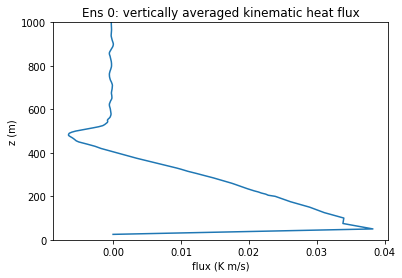

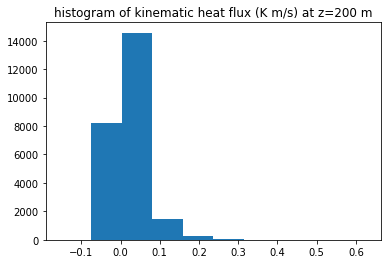

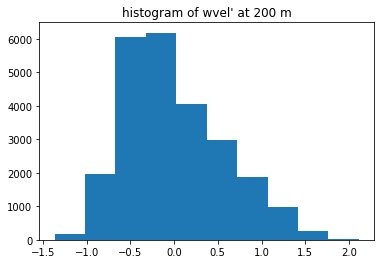

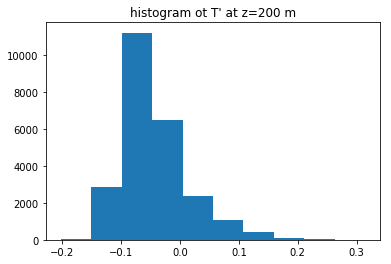

In [6]:
fig1, ax1 = plt.subplots(1, 1)
ax1.plot(var_tup.flux_prof, var_tup.z)
ax1.set(ylim=[0, 1000], title='Ens 0: vertically averaged kinematic heat flux',
        ylabel='z (m)', xlabel='flux (K m/s)')

fig2, ax2 = plt.subplots(1, 1)
z200 = np.searchsorted(var_tup.z, 200)
ax2.hist(var_tup.flux_prime[z200, :, :].flat)
ax2.set(title='histogram of kinematic heat flux (K m/s) at z=200 m')

fig3, ax3 = plt.subplots(1, 1)
ax3.hist(var_tup.wvelprime[z200, :, :].flat)
ax3.set(title="histogram of wvel' at 200 m")

fig4, ax4 = plt.subplots(1, 1)
ax4.hist(var_tup.Tprime[z200, :, :].flat)
ax4.set(title="histogram ot T' at z=200 m");



# Conditional sampling the flux

Write 100 where there is postively buoyant ascending air and 1 everywhere else"

In [7]:
hit = np.logical_and(var_tup.wvelprime > 0, var_tup.Tprime > 0)

pos_buoyant = np.ones_like(var_tup.flux_prime, dtype=np.float32)
#pos_buoyant[hit] = var_tup.flux_prime[hit]
pos_buoyant[hit] = pos_buoyant[hit]*100.

# writing a vapor vdf file

First we need to output the x, y and z coordinates in separate files

In [8]:
filenames = ['xvals.txt', 'yvals.txt', 'zvals.txt']
arrays = [var_tup.x, var_tup.y, var_tup.z]
for name, vals in zip(filenames, arrays):
    print (type(vals))
    with open(name, 'w') as outfile:
        if firstrun:
            #
            # write all but the last without a newline
            #
            [outfile.write('{:6.3f} '.format(item)) for item in vals.values[:-1]]
            #
            # write the last value with a newline
            #
            outfile.write('{:6.3f}\n'.format(vals.values[-1]))
        else:
            #
            # write all but the last without a newline
            #
            [outfile.write('{:6.3f} '.format(item)) for item in vals[:-1]]
            #
            # write the last value with a newline
            #
            outfile.write('{:6.3f}\n'.format(vals[-1]))
            

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>


In [9]:
varname = 'buoyancy'
out_name = '{}.bin'.format(varname)
rev_shape = pos_buoyant.shape[::-1]
string_shape="{}x{}x{}".format(*rev_shape)
print('writing an array of {} of shape x,y,z= {}'.format(varname,string_shape))
fp = np.memmap(out_name, dtype=np.float32,
               mode='w+', shape=pos_buoyant.shape)
fp[...] = pos_buoyant[...]

writing an array of buoyancy of shape x,y,z= 192x128x312


Now write out a bash script that supply the data for vdfcreate

In [10]:
 vars=dict(dim=string_shape,var='buoyancy')
    
command=r"""
    vdfcreate  -xcoords xvals.txt -ycoords yvals.txt -zcoords zvals.txt \
       -gridtype stretched -dimension {dim:s} -vars3d {var:s} -numts 1 {var:s}.vdf

    raw2vdf -varname {var:s} -ts 0 {var:s}.vdf {var:s}.bin
"""
out=textwrap.dedent(command.format_map(vars))
with open('make_vapor.sh','w') as f:
    f.write('#!/bin/bash -v\n')
    f.write(out)

In [11]:
!cat make_vapor.sh

#!/bin/bash -v

vdfcreate  -xcoords xvals.txt -ycoords yvals.txt -zcoords zvals.txt \
   -gridtype stretched -dimension 192x128x312 -vars3d buoyancy -numts 1 buoyancy.vdf

raw2vdf -varname buoyancy -ts 0 buoyancy.vdf buoyancy.bin


Now open a terminal (osx) or a bash-shell (windows) and setup the path for vapor
following these [osx instructions](https://www.vapor.ucar.edu/docs/vapor-installation/vapor-mac-binary-installation) or these
[windows instructions]( https://www.vapor.ucar.edu/docs/vapor-installation/vapor-windows-binary-installation)

Once you've done this, vdfcreate and raw2vdf should be in our path, and
you should  be able to do:

```bash
> bash make_vapor.sh
```

If this works, there should be a new file called

  buoyancy.vdf
  
and a new folder called

  buoyancy_data
  
Now executate

  vaporgui
  
from the same terminal